[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mdfabbro/TFQ-Colab/blob/main/TFQ-Basics.ipynb)


# **Basics**
### Resume
We will create a circuit and then a Controlled PQC layer.

## References
Based on: 
https://www.tensorflow.org/quantum/tutorials/hello_many_worlds

---

## Installation
We will install TF 2.5.1 (version required by TFQ) and TF-Quantum. 
> Check https://www.tensorflow.org/quantum/install for updates.


In [ ]:
%%capture
!pip install -q tensorflow==2.5.1

In [ ]:
%%capture
!pip install -q -U tensorflow-quantum

In [ ]:
%%capture
!pip install -q -U tfq-nightly

In [ ]:
!pip show tensorflow
!pip show tensorflow-quantum
!pip show tfq-nightly

In [ ]:
import importlib, pkg_resources
importlib.reload(pkg_resources)

<module 'pkg_resources' from '/usr/local/lib/python3.7/dist-packages/pkg_resources/__init__.py'>

In [ ]:
import tensorflow as tf
import tensorflow_quantum as tfq
import cirq
import sympy
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit



---


# First circuit

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


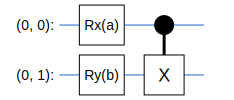

In [ ]:
# Lets create parameters
a, b = sympy.symbols('a b')

# Create two qubits
q0, q1 = cirq.GridQubit.rect(1, 2)

# Create a circuit on these qubits using the parameters you created above.
circuit = cirq.Circuit(
    cirq.rx(a).on(q0),
    cirq.ry(b).on(q1), cirq.CNOT(control=q0, target=q1))

SVGCircuit(circuit)

## Simulation

In [ ]:
# Calculate a state vector with a=0.5 and b=-0.5.
resolver = cirq.ParamResolver({a: 0.5, b: -0.5})
output_state_vector = cirq.Simulator().simulate(circuit, resolver).final_state_vector
print(output_state_vector) # This are the prob of each state.

[ 0.9387913 +0.j         -0.23971277+0.j          0.        +0.06120872j
  0.        -0.23971277j]


In [ ]:
# Measuring
# Example 1: Measuring in Z the qubit 0. 
# In this case Z = 1 means |0> and Z = -1 is |1>
z0 = cirq.Z(q0)
qubit_map={q0: 0, q1: 1}
print("Z0 =",z0.expectation_from_state_vector(output_state_vector, qubit_map).real)

# Example 2: Measuring in 1/2*Z0 + X1
z0x1 = cirq.Z(q0) * 0.5 + cirq.X(q1)
qubit_map={q0: 0, q1: 1}
print("1/2*Z0 + X1 =",z0x1.expectation_from_state_vector(output_state_vector, qubit_map).real)


Z0 = 0.8775825500488281
1/2*Z0 + X1 = -0.04063427448272705


## Tensors

In [ ]:
# Lets convert the circuit into a tensor.
circuit_tensor = tfq.convert_to_tensor([circuit])
print(circuit_tensor.shape) # (1,)
print(circuit_tensor.dtype) # 'string'

(1,)
<dtype: 'string'>


In [ ]:
# Rank 1 tensor containing 2 Pauli operators.
pauli_tensor = tfq.convert_to_tensor([z0, z0x1])
pauli_tensor.shape # The shape is 2 as there are two operators: ([2])

TensorShape([2])

### Batch of values

In [ ]:
# Batch of values to replace a and b.
# This values will be uniformly distributed.
batch_vals = np.array(np.random.uniform(0,2*np.pi, (5,2)),dtype = np.float32)
print(batch_vals)

[[5.341163  1.0670136]
 [3.692997  5.0539026]
 [5.599125  2.4432404]
 [3.050511  4.89876  ]
 [4.5540233 5.4944158]]


In [ ]:
# Option 1
cirq_results = []
cirq_simulator = cirq.Simulator()

for vals in batch_vals:
    resolver = cirq.ParamResolver({a: vals[0], b: vals[1]})
    final_state_vector = cirq_simulator.simulate(circuit, resolver).final_state_vector
    cirq_results.append(
        [z0.expectation_from_state_vector(final_state_vector, qubit_map).real])

print('cirq batch results: \n {}'.format(np.array(cirq_results)))

cirq batch results: 
 [[ 0.58815384]
 [-0.85178971]
 [ 0.77501315]
 [-0.99585497]
 [-0.15770465]]


In [ ]:
# Option 2: Using the right method
# We are measuring in Z to get a value in the range [-1,1].
tfq.layers.Expectation()(circuit,
                         symbol_names=[a, b],
                         symbol_values=batch_vals,
                         operators=z0)

<tf.Tensor: shape=(5, 1), dtype=float32, numpy=
array([[ 0.5881554 ],
       [-0.85178906],
       [ 0.7750144 ],
       [-0.995855  ],
       [-0.15770268]], dtype=float32)>

## Hybrid

We will start creating the circuit that needs to be calibrated and the one that will be controlled.
There will be 3 random values of Θx, Θy and Θz used to rated in X, Y and Z a qubit initialized in the state |0>.

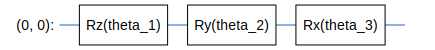

In [ ]:
# Parameters that the classical NN will feed values into.
control_params = sympy.symbols('theta_1 theta_2 theta_3')

# Create the parameterized circuit.
qubit = cirq.GridQubit(0, 0)
model_circuit = cirq.Circuit(
    cirq.rz(control_params[0])(qubit),
    cirq.ry(control_params[1])(qubit),
    cirq.rx(control_params[2])(qubit))

SVGCircuit(model_circuit)

Lets now create the neural network. That will be used to control 3 gates, so
we need 3 outputs and the inputs will be '0' or '1' to set the final output in |0> or |1>

In [ ]:
# The classical neural network layers.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

In [ ]:
# Lets check that it is initialized with random values.
# Lets send '0' and '1' as control signal and see the outputs.
controller(tf.constant([[0.0],[1.0]])).numpy()

array([[ 0.        ,  0.        ,  0.        ],
       [-0.64121115,  0.4463898 ,  0.16676027]], dtype=float32)

In [ ]:
# This input is the simulated miscalibration that the model will learn to correct.
# So the it is the result of applying the first 3 gates and it is the input of
# the next 3 inputs.
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype 'tf.string'
                                dtype=tf.string,
                                name='circuits_input')

# Commands will be either '0' or '1', specifying the state to set the qubit to.
commands_input = tf.keras.Input(shape=(1,),
                                dtype=tf.dtypes.float32,
                                name='commands_input')

In [ ]:
# The commands_input is the input of out neural network.
dense_2 = controller(commands_input)

# LAYER: Controlled Parametrized Quantum Circuit 
# TFQ layer for classically controlled circuits.
expectation_layer = tfq.layers.ControlledPQC(model_circuit,
                                             # Observe Z
                                             operators = cirq.Z(qubit))

# This is not the case, but we can replace the circuits_input by actually
# a circuit.
expectation = expectation_layer([circuits_input, dense_2])

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [ ]:
# The full Keras model is built from our layers.
model = tf.keras.Model(inputs=[circuits_input, commands_input],
                       outputs=expectation)

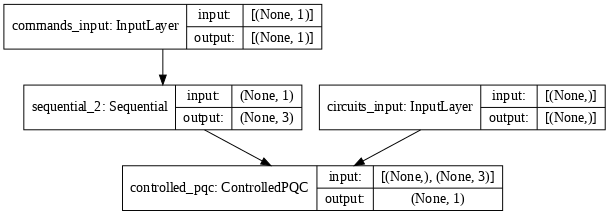

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=70)

### Dataset
We will create the dataset. In this case, it is super simple, we want a '0'->1 and '1'->-1.

In [ ]:
# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)
# The desired Z expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [ ]:
# This is the circuit that will be put the qubit in a state that needs to be 
# callibrated.
random_rotations = np.random.uniform(0, 2 * np.pi, 3)
noisy_preparation = cirq.Circuit(
  cirq.rx(random_rotations[0])(qubit),
  cirq.ry(random_rotations[1])(qubit),
  cirq.rz(random_rotations[2])(qubit)
)
# Make two copied of this circuit
# NOTE: We need two copies are there are two commands and in both cases the
# inputs were the same.
datapoint_circuits = tfq.convert_to_tensor([noisy_preparation] * 2)  

In [ ]:
# We have two copies of the circuit. It should be shape 2!
print("Shape of datapoint_circuit = ", datapoint_circuits.shape)
print("Shape of commands = ", commands.shape)

Shape of datapoint_circuit =  (2,)
Shape of commands =  (2, 1)


### Training

In [ ]:
model([datapoint_circuits, commands]).numpy()

array([[-0.9099674],
       [-0.9018942]], dtype=float32)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()
model.compile(optimizer=optimizer, loss=loss)
history = model.fit(x=[datapoint_circuits, commands],
                    y=expected_outputs,
                    epochs=30,
                    verbose=0)

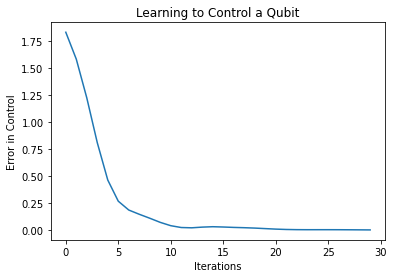

In [ ]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()



---


# Second circuit
The idea is to do the same but now with a circuit that maps +Z (|0>) and -X (|->).

In [ ]:
# Define inputs.
commands_input = tf.keras.layers.Input(shape=(1),
                                       dtype=tf.dtypes.float32,
                                       name='commands_input')
circuits_input = tf.keras.Input(shape=(),
                                # The circuit-tensor has dtype `tf.string` 
                                dtype=tf.dtypes.string,
                                name='circuits_input')
operators_input = tf.keras.Input(shape=(1,),
                                 dtype=tf.dtypes.string,
                                 name='operators_input')

In [ ]:
# Define classical NN.
controller = tf.keras.Sequential([
    tf.keras.layers.Dense(10, activation='elu'),
    tf.keras.layers.Dense(3)
])

In [ ]:
dense_2 = controller(commands_input)

# Since you aren't using a PQC or ControlledPQC you must append
# your model circuit onto the datapoint circuit tensor manually.
full_circuit = tfq.layers.AddCircuit()(circuits_input, append=model_circuit)
expectation_output = tfq.layers.Expectation()(full_circuit,
                                              symbol_names=control_params,
                                              symbol_values=dense_2,
                                              operators=operators_input)

# Contruct your Keras model.
two_axis_control_model = tf.keras.Model(
    inputs=[circuits_input, commands_input, operators_input],
    outputs=[expectation_output])

In [ ]:
# The operators to measure, for each command.
operator_data = tfq.convert_to_tensor([[cirq.X(qubit)], [cirq.Z(qubit)]])

# The command input values to the classical NN.
commands = np.array([[0], [1]], dtype=np.float32)

# The desired expectation value at output of quantum circuit.
expected_outputs = np.array([[1], [-1]], dtype=np.float32)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
loss = tf.keras.losses.MeanSquaredError()

two_axis_control_model.compile(optimizer=optimizer, loss=loss)

history = two_axis_control_model.fit(
    x=[datapoint_circuits, commands, operator_data],
    y=expected_outputs,
    epochs=30,
    verbose=1)

Epoch 1/30
1/1 [==============================] - 1s 652ms/step - loss: 0.1766
Epoch 2/30
1/1 [==============================] - 0s 8ms/step - loss: 0.0402
Epoch 3/30
1/1 [==============================] - 0s 7ms/step - loss: 0.0196
Epoch 4/30
1/1 [==============================] - 0s 6ms/step - loss: 0.0301
Epoch 5/30
1/1 [==============================] - 0s 5ms/step - loss: 0.0345
Epoch 6/30
1/1 [==============================] - 0s 6ms/step - loss: 0.0167
Epoch 7/30
1/1 [==============================] - 0s 8ms/step - loss: 0.0053
Epoch 8/30
1/1 [==============================] - 0s 7ms/step - loss: 0.0019
Epoch 9/30
1/1 [==============================] - 0s 18ms/step - loss: 0.0014
Epoch 10/30
1/1 [==============================] - 0s 8ms/step - loss: 0.0024
Epoch 11/30
1/1 [==============================] - 0s 11ms/step - loss: 0.0039
Epoch 12/30
1/1 [==============================] - 0s 7ms/step - loss: 0.0046
Epoch 13/30
1/1 [==============================] - 0s 8ms/step - loss

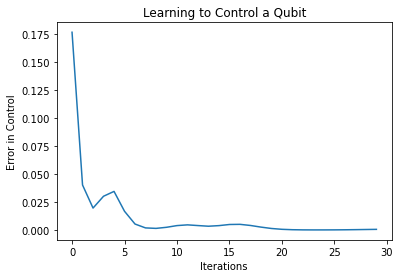

In [ ]:
plt.plot(history.history['loss'])
plt.title("Learning to Control a Qubit")
plt.xlabel("Iterations")
plt.ylabel("Error in Control")
plt.show()

In [ ]:
controller.predict(np.array([0,1]))

array([[-0.82750064,  0.285445  ,  0.21234037],
       [-0.24714042,  1.6370709 , -0.58882546]], dtype=float32)